In [1]:
import cv2
import os
import numpy as np
import time
import torch
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

In [4]:
from models import *
from utils import get_transformation_matrix

In [ ]:
# Initial = fc
models = [
    {
        "folder": "02_resnet18_MSE",
        "checkpoint": "model-9.pt",
        "type": "concatenation"
    },
    {
        "folder": "16_sub_MSE_fc",
        "checkpoint": "checkpoint-20.pt",
        "type": "subtraction"
    },
    {
        "folder": "07_resnet18_MSE_corr_2",
        "checkpoint": "checkpoint-24.pt",
        "type": "correlation"
    },
]

m = models[1]
outputs_path = "/content/drive/MyDrive/outputs"
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initial_siamese_resnet18(1, 7, m["type"])
if m["type"] == "concatenation":
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device))
else:
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

In [7]:
# Reg
models = [
    {
        "folder": "17_cat_MSE_reg",
        "checkpoint": "checkpoint-20.pt",
        "channels": [1024, 128, 64],
        "type": "concatenation"
    },
    {
        "folder": "15_sub_MSE_reg",
        "checkpoint": "checkpoint-19.pt",
        "channels": [512, 128, 64],
        "type": "subtraction"
    },
    {
        "folder": "08_resnet18_MSE_corr_reg", # 11_resnet18_wMSE_corr_reg_4
        "checkpoint": "checkpoint-20.pt", # 17
        "channels": [384, 128, 64],
        "type": "correlation"
    },
]

m = models[2]
outputs_path = "/content/drive/MyDrive/outputs"
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = siamese_resnet18(1, 7, m["type"], m["channels"])
model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
model.cuda()
model.eval()

print(f"Running on {device}")

Running on cuda


In [8]:
tr_only = False
reg_on_first = True
video_name = "Study_02_00008_02_R"
cap = cv2.VideoCapture(f"/content/drive/MyDrive/data/{video_name}.avi")
# Find the number of frames
video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
count = 0
# Start converting the video
image_list = []
image_list_warped = []
time_start = time.time()
with tqdm(total=video_length, unit=' frames') as pbar:
    while cap.isOpened():
        # Extract the frame

        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if not ret:
            continue
        if len(image_list) == 0:
            image_list.append(frame)
            image_list_warped.append(frame)
        else:
            if reg_on_first:
                frame0 = image_list_warped[0]
                frame1 = frame
            else:
                frame0 = image_list_warped[count-1]
                frame1 = frame

            h = 500
            w = int(h * 1.5)
            rows, cols = frame0.shape
            center = (cols//2, rows//2)
            img0 = torch.unsqueeze(transforms.functional.to_tensor(frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]), 1).to(device)
            img1 = torch.unsqueeze(transforms.functional.to_tensor(frame1[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2]), 1).to(device)

            start = time.perf_counter()
            outputs = model(img0, img1)
            end = time.perf_counter()
            #print(f"{count}, time: {end - start}")

            if tr_only:
                tx, ty, _, _, _, _, _ = outputs.detach().cpu().numpy().reshape(-1).tolist()
                mat = np.array([
                        [1, 0, tx],
                        [0, 1, ty],
                        [0, 0, 1],
                    ])
                matrix_opencv = np.float32(mat.flatten()[:6].reshape(2, 3))
                inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
                frame1_warped = cv2.warpAffine(frame1, inverse_matrix, (cols, rows))
            else:
                tx, ty, sx, sy, shx, shy, q = outputs.detach().cpu().numpy().reshape(-1).tolist()
                matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
                matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
                inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
                frame1_warped = cv2.warpAffine(frame1, inverse_matrix, (cols, rows))

            
            image_list.append(frame)
            image_list_warped.append(frame1_warped)
            
            #cap.release()
            #break


        
        count = count + 1
        pbar.update(1)
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            break

100%|██████████| 253/253 [00:14<00:00, 17.21 frames/s]


In [ ]:
img = np.concatenate((image_list[0], image_list_warped[0]), axis = 1)

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
#out = cv2.VideoWriter(os.path.join(outputs_path, folder,f'_{video_name}_tr.mp4'), cv2.VideoWriter_fourcc(*'XVID'), 15, (img.shape[1], img.shape[0]), 0)
out = cv2.VideoWriter(os.path.join(outputs_path, folder, f'{video_name}.mp4'), cv2.VideoWriter_fourcc(*'XVID'), 15, (img.shape[1], img.shape[0]), 0)

for image, image_warped in zip(image_list, image_list_warped):
    img = np.concatenate((image, image_warped), axis = 1)
    I = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    cv2.putText(img=I, text='Original', org=(325, 75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255, 0, 255), thickness=3)
    cv2.putText(img=I, text='Registered', org=(1275, 75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(255, 0, 255), thickness=3)
    out.write(I)

cv2.destroyAllWindows()
out.release()

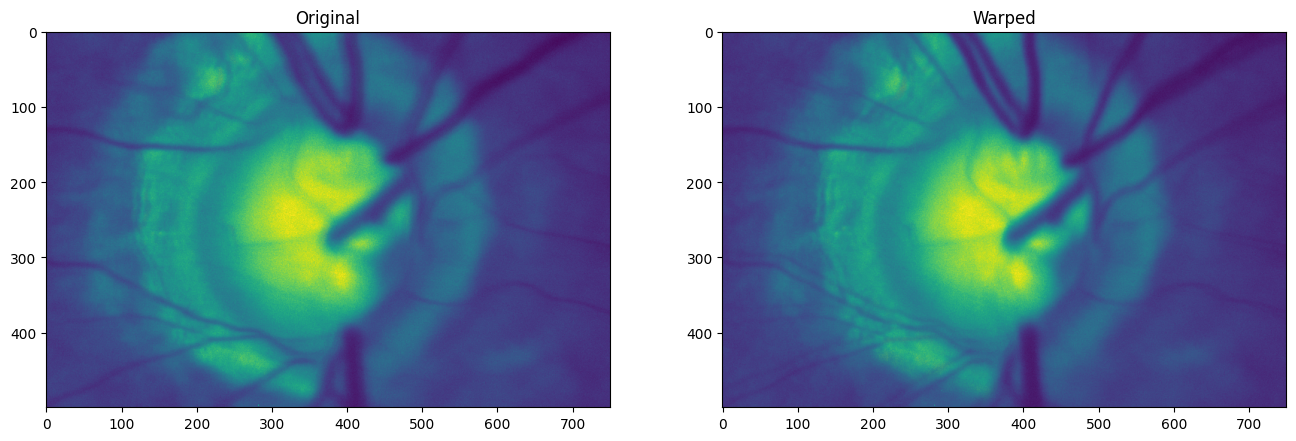

In [23]:
plt.figure(figsize = (16,9))
plt.subplot(121)
plt.title('Original')
plt.imshow(frame0)
plt.imshow(frame1, alpha=0.4)

plt.subplot(122)
plt.title('Warped')
plt.imshow(frame0)
plt.imshow(frame1_warped, alpha=0.4)

plt.show()

In [22]:
((frame0[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2] - frame1_warped[center[1] - h // 2:center[1] + h // 2, center[0] - w // 2:center[0] + w // 2])**2).mean()

65.416656

In [20]:
((frame0 - frame1)**2).mean()

51.56354155844156

In [30]:
from skimage.metrics import structural_similarity as ssim

In [24]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [29]:
mse(frame0, frame1_warped)

229.647824

In [32]:
ssim(frame0, frame1_warped)

0.5637306965204089

In [ ]:
tx, ty, sx, sy, shx, shy, q

NameError: ignored

In [ ]:
mat = np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1],
    ]) @ np.array([
        [1, 0, center[0]],
        [0, 1, center[1]],
        [0, 0, 1],
    ]) @ np.array([
        [np.cos(q), -np.sin(q), 0],
        [np.sin(q), np.cos(q), 0],
        [0, 0, 1]
    ]) @ np.array([
        [1, 0, -center[0]],
        [0, 1, -center[1]],
        [0, 0, 1],
    ])  